# Imputation for two modalities

In [1]:
import os
import sys
os.environ["OMP_NUM_THREADS"] = "11"
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "11" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "11" # export NUMEXPR_NUM_THREADS=6
os.environ["NUMBA_CACHE_DIR"]='/tmp/numba_cache'
import numpy as np
import pandas as pd
import scipy as sp
import scipy.sparse
import h5py

import tensorflow as tf
import matplotlib.pyplot as plt
import scanpy as sc

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

2025-06-07 03:44:20.607049: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-07 03:44:20.627913: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-07 03:44:20.627927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-07 03:44:20.628482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-07 03:44:20.631565: I tensorflow/core/platform/cpu_feature_guar

## Load data

In [2]:
with h5py.File('dogma_cite_asap.h5', 'r') as f:
    print(f.keys())
    ADT_names = np.array(f['ADT_names'], dtype='S32').astype(str)
    gene_names = np.array(f['gene_names'], dtype='S32').astype(str)
    
    # Count matrices of three modalities: X for genes, Y for ADT, and Z for peaks.
    X = sp.sparse.csc_matrix(
        (np.array(f['RNA.data'], dtype=np.float32), 
         np.array(f['RNA.indices'], dtype=np.int32),
         np.array(f['RNA.indptr'], dtype=np.int32)
        ), 
        shape = np.array(f['RNA.shape'], dtype=np.int32)).tocsc().astype(np.float32)
    Y = np.array(f['ADT'], dtype=np.float32)
    cell_types = np.array(f['cell_types'], dtype='S32').astype(str)
    
    # The covariate matrix, the last column is the ids of datasets
    batches = np.array(f['batches'], dtype=np.float32)
    
    # The indices of features that are observed in each dataset.
    id_X_cite = np.array(f['id_X_cite'], dtype=np.int32)
    id_Y_cite = np.array(f['id_Y_cite'], dtype=np.int32)
    id_Y_asap = np.array(f['id_Y_asap'], dtype=np.int32)
    
    # The sample size
    sample_sizes = np.array(f['sample_sizes'], dtype=np.int32)

# Preprocess the data
X = X.toarray()
X[batches[:,-1]!=2,:] = np.log(X[batches[:,-1]!=2,:]/np.sum(X[batches[:,-1]!=2,:], axis=1, keepdims=True)*1e4+1.)
Y = np.log(Y/np.sum(Y, axis=1, keepdims=True)*1e4+1.)
data = np.c_[X, Y]

# Subset the data, only use CITE-seq and ASAP-seq datasets for illustration.
batches = batches[sample_sizes[0]:]
data = data[sample_sizes[0]:]
sample_sizes = sample_sizes[1:]


gene_names = gene_names[id_X_cite] # remove genes not measured in the two datasets
id_Y_cite_val = np.random.choice(id_Y_cite, int(0.1*len(id_Y_cite)), replace=False)
id_Y_cite = np.setdiff1d(id_Y_cite, id_Y_cite_val)
dim_input_arr = np.array([len(gene_names),len(ADT_names)])

data = data[:, np.r_[id_X_cite, id_Y_asap+dim_input_arr[0]]]
data_raw = data.copy()


# The masks indicate missing pattern for the whole datasets.
masks_raw = - np.ones_like(data, dtype=np.float32)
masks_raw[:sample_sizes[0], :] = 0.
masks_raw[sample_sizes[0]:, dim_input_arr[0]:] = 0.

# randomly remove 20% of entries to be missing
# Each row corresponds to a cell, and each column corresponds to a feature.
# If the dataset is large, one can also provide a mask matrix with shape (num_datasets, num_features)
# along with a variable `id_datasets` to reduce memory usages.
# -1 means missing and 0 means observed.
masks = masks_raw.copy()
masks[np.random.rand(*masks.shape) < 0.2] = -1
data = data * (masks != -1)
masks = tf.convert_to_tensor(masks, dtype=tf.float32)

print('Sample sizes: {}. Feature sizes: {}.'.format(sample_sizes, dim_input_arr))

<KeysViewHDF5 ['ADT', 'ADT_names', 'RNA.data', 'RNA.indices', 'RNA.indptr', 'RNA.shape', 'batches', 'cell_ids', 'cell_types', 'gene_names', 'id_X_cite', 'id_X_dogma', 'id_Y_asap', 'id_Y_cite', 'id_Y_dogma', 'id_Z_asap', 'id_Z_dogma', 'peak_names', 'peaks.data', 'peaks.indices', 'peaks.indptr', 'peaks.shape', 'sample_sizes']>
Sample sizes: [8689 8535]. Feature sizes: [2374  227].


2025-06-07 03:44:36.886871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-07 03:44:36.887006: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-07 03:44:36.887059: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Set up config for model training

In [ ]:
import sys; sys.path.insert(0, '../../../../') # add parent folder path if not installed via PyPI
import scVAEIT
print(scVAEIT.__version__)

from scVAEIT import VAEIT

path_root = 'result/2/'

config = {
    # Dimension of input features for [RNA, ADT, peaks]
    'dim_input_arr': dim_input_arr,

    # Blocks for [RNA, ADT]
    'dim_block': np.array([len(gene_names),len(ADT_names)]), # input dimension of blocks
    'dist_block':['NB','NB'], # distributions of blocks
    'dim_block_enc':np.array([128, 64]), # dimension of first layer of the encoder
    'dim_block_dec':np.array([128, 64]), # dimension of first layer of the decoder
    'dim_block_embed':np.array([128, 64]), # mask embedding dimension

    # Internal network structure
    'dimensions':[32], # dimension of latent layers of encoder; the reversed is used for decoder
    'dim_latent':8, # the latent dimension between the encoder and decoder

    # Weights
    'beta_unobs':.9, # weight for masked out observation; weight for observed values will be 1-beta_unobs.
    'beta_modal':np.array([0.05,0.95]), # weights for 2 modalities, which can be adjusted based on loss in the first few epochs.

    # Masking probability
    "p_feat" : 0.5, # probability of randomly masking out an entry
}

batches_cate = batches
batches_cont = None

model = VAEIT(config, data, masks, None, batches_cate, batches_cont)

1.1.0
Missingness (overall): 0.5618
Missingness (per row): mean=0.5618, min=0.1696, max=0.9389
Missingness (per column): mean=0.5618, min=0.1923, max=0.6039
namespace(beta_kl=2.0, beta_unobs=0.9, beta_reverse=0.0, beta_modal=array([0.05, 0.95]), p_modal=None, p_feat=0.5, uni_block_names=array(['M-0', 'M-1'], dtype='<U23'), block_names=array(['M-0', 'M-1'], dtype='<U23'), dist_block=array(['NB', 'NB'], dtype='<U2'), dim_block=array([2374,  227]), dim_block_enc=array([128,  64], dtype=int32), dim_block_dec=array([128,  64], dtype=int32), skip_conn=False, mean_vals=<tf.Tensor: shape=(2601,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, min_vals=<tf.Tensor: shape=(2601,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, max_vals=<tf.Tensor: shape=(2601,), dtype=float32, numpy=
array([8.865503 , 8.865503 , 8.865503 , ..., 6.5426416, 6.5426416,
       6.5426416], dtype=float32)>, max_disp=6.0, max_zi_prob=None, gamma=0.0, dim_input_arr=

In [4]:
# Here we only train for 300 epochs for illustration purpose
hist = model.train(
        num_epoch=300, batch_size=256, save_every_epoch=50,
        verbose=True, checkpoint_dir=path_root+'checkpoint/')

Deleting old log directory at example/result/2/checkpoint/
Train - Start of epoch 1


2025-06-07 03:44:41.904367: I external/local_xla/xla/service/service.cc:168] XLA service 0x615982b752c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-07 03:44:41.904383: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-06-07 03:44:41.906431: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-07 03:44:41.914470: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1749267881.957988 3938238 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/67 [==============================] - 6s 95ms/step - Reconstructed Loss: 178.8202
Epoch 1, Time elapsed: 0.11 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :  187.82,    8.56,   27.83,   71.62,   68.92,   10.88,    0.00
Train - Start of epoch 2
67/67 [==============================] - 2s 33ms/step - Reconstructed Loss: 104.4566
Epoch 2, Time elapsed: 0.14 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :  106.74,    4.84,   22.03,   42.03,   35.02,    2.82,    0.00
Train - Start of epoch 3
67/67 [==============================] - 2s 33ms/step - Reconstructed Loss: 71.8717
Epoch 3, Time elapsed: 0.18 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl,     mmd
train :   70.97,    3.95,   14.95,   33.36,   17.21,    1.50,    0.00
Train - Start of epoch 4
67/67 [==============================] - 2s 31ms/step - Reconstructed Loss: 61.5277
Epoch 4, Time elapsed: 0.21 minutes
          t

We can visualize the training loss. It fluctuates since we argument the data with random masking, which also provides regularization against overfitting.
One may continue training until the loss gets stabilized.

Text(0, 0.5, 'Trianing loss')

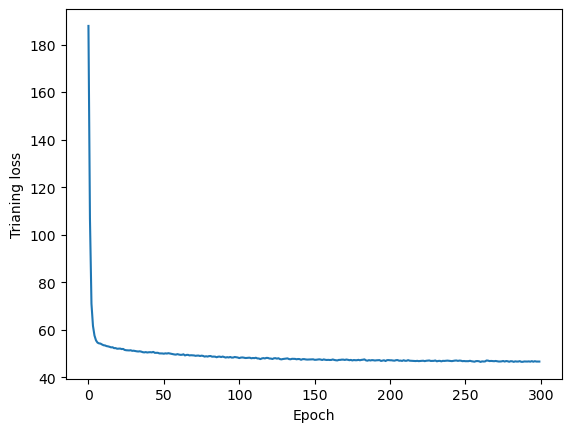

In [5]:
plt.plot(hist['train']['total'])
plt.xlabel('Epoch')
plt.ylabel('Trianing loss')

For later usage, we can load the trained model through the `load_model` method without the need to retrain:

```python
model.load_model(path_root+'checkpoint/')
```

## Inspect imputation results

In [6]:
denoised_data = model.get_denoised_data()

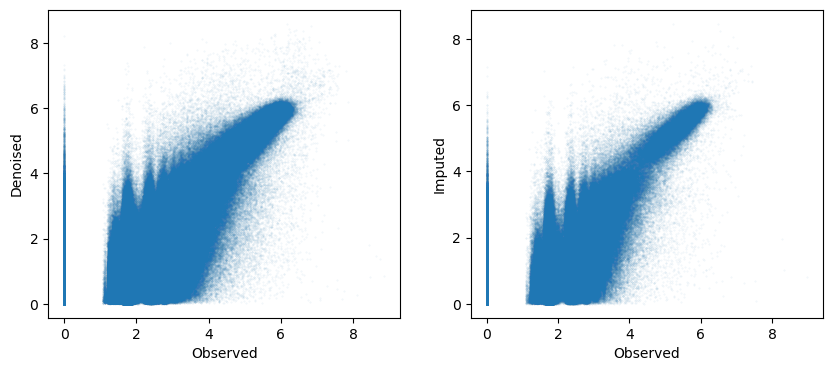

In [7]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(
    data_raw[masks==0],
    denoised_data[masks==0], s=0.1, alpha=0.1
    )
axes[0].set_xlabel('Observed')
axes[0].set_ylabel('Denoised')

axes[1].scatter(
    data_raw[(masks_raw==0)&(masks==-1)],
    denoised_data[(masks_raw==0)&(masks==-1)], s=0.1, alpha=0.1
    )
axes[1].set_xlabel('Observed')
axes[1].set_ylabel('Imputed')
plt.show()